## Lesson8 and 9 pascal object detecion applied to Tiny ImageNet Visual Recognition Challenge
https://tiny-imagenet.herokuapp.com/

"*Tiny Imagenet has 200 classes. Each class has 500 training images, 50 validation images, and 50 test images. We have released the training and validation sets with images and annotations. We provide both class labels and bounding boxes as annotations; however, you are asked only to predict the class label of each image without localizing the objects. The test set is released without labels*"


In [47]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [48]:
from IPython.core.debugger import set_trace

from os import listdir
from os.path import isfile, join
import csv

from pathlib import Path
import json
from matplotlib import patches, patheffects
from scipy.special import expit

from fastai.conv_learner import *
from fastai.dataset import *



In [49]:
#for pycharm notebooks
plt.ion()

In [50]:
PATH = Path('/mnt/samsung_1tb/Data/fastai/tiny-imagenet/tiny_imagenet_restructured/')

In [51]:
os.listdir(PATH)

['test',
 'models',
 'words.txt',
 'yukez.txt',
 'readme.txt',
 'train',
 'val',
 'tmp',
 'wnids.txt']

Stage 1: re-structure the data layout and file structures 

    JPEGS: all images in one directory
    find . -name \*.JPEG -exec cp {} /path/tiny_imagenet_restructured/train/JPEGImages/ \;
    find . -name \*boxes.txt -exec cp {} /path/tiny_imagenet_restructured/train/Boxes/ \;
    CSV: create df of filename, category

Stage 2: read the data in to pascal.ipynb-like dicts

ie we want 

    trn_anno: trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    #trn_anno is a dict of {id, [(bbox, category_id), ...]} where coords are TL, BR numpy consistent x,y coords

    cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
    trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
    trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [52]:
JPEGS = 'train/JPEGImages'
IMG_PATH = PATH/JPEGS

In [53]:
df_submission_example  = pd.read_csv(PATH/'yukez.txt', names=['file_name', 'code'], delim_whitespace=True)


In [54]:
df_submission_example.head(n=2)

,file_name,code
0,test_0.JPEG,n04067472
1,test_1.JPEG,n02788148


In [55]:
code_words = {}

with open(PATH/'words.txt') as f:
  for row in csv.reader(f, delimiter="\t"):
    #We keep only the first of the descriptions
    code = row[1].split(",")[0]
    #replace whitespaces with underscore
    code = "_".join(code.split()).strip().lower()
    code_words[row[0]] = code

In [56]:
wnids = [line.strip() for line in open(PATH/'wnids.txt', 'r')]
#eg ['n02124075', 'n04067472', 'n04540053',...]

In [57]:
#keep only those words from our images
code_words = {k: code_words[k] for k in wnids}
#eg {'n01443537': 'goldfish', 'n01629819': 'European fire salamander',...
#code_words

In [58]:
cats = dict(enumerate(x for x in code_words.values()))
#cats eg {0: 'Egyptian cat', 1: 'reel',...

In [59]:
fn_bbox = {}
txt_files = [i for i in os.listdir(PATH/'train/Boxes/') if os.path.splitext(i)[1] == '.txt']

for f in txt_files:
    with open(os.path.join(PATH/'train/Boxes/',f)) as file_object:
        for row in csv.reader(file_object, delimiter="\t"):
            fn_bbox[row[0]] = row[1]+' '+row[2]+' '+row[3]+' '+row[4]

In [60]:
#note there is only a single bounding box per image
#ie {'n02837789_0.JPEG': '8 8 40 63', 'n02837789_1.JPEG': '32 24 54 39',...
#fn_bbox

In [61]:
file_id_df = pd.DataFrame({'file_id':wnids})
file_id_df.head(n=2)

,file_id
0,n02124075
1,n04067472


In [62]:
jpeg_filenames = [f for f in listdir(IMG_PATH) if isfile(join(IMG_PATH, f))]
jpeg_filenames.sort()
jpeg_fn_df = pd.DataFrame(jpeg_filenames)
trn_fns = list(jpeg_fn_df.to_dict().values())[0]
#eg {0: 'n01443537_0.JPEG', 1: 'n01443537_1.JPEG',...

In [63]:
#so we can look up by value
inv_trn_fns = {v: k for k, v in trn_fns.items()}
inv_cats = {v: k for k, v in cats.items()}
trn_anno = collections.defaultdict(lambda:[])
for k, v in fn_bbox.items():
    core_code = k.split('_')[0]
    bb = fn_bbox[k].split()
    bb = np.array([bb[0], bb[1], bb[2], bb[3]])
    bb = bb.astype(np.int16)
    cat_id = inv_cats[code_words[core_code]]
    trn_anno[inv_trn_fns[k]].append((bb, cat_id))
#trn_anno
im_a = trn_anno[37000]; im_a

[(array([ 8,  8, 40, 63], dtype=int16), 142)]

In [64]:
#conversion between numpy style and cs style
def bb_hw(a): 
    return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [65]:
im = open_image(IMG_PATH/trn_fns[0])

In [66]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [67]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [68]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [69]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [70]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [71]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

In [72]:
def get_lrg(b):
    if not b: 
        raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [73]:
#not necessary as only 1 bbox per image, TODO remove this call
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

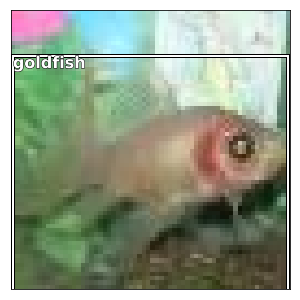

In [74]:
b,c = trn_lrg_anno[0]
#b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[0]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)
plt.show()

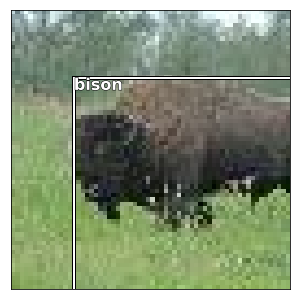

In [75]:
b,c = trn_lrg_anno[25000]
#b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[25000]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)
plt.show()

In [76]:
b

array([14, 15, 63, 53], dtype=int16)

In [77]:
#create filename, category CSV
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [78]:
fn_cat_dict = {}
for k, v in trn_fns.items():
    core_code = v.split('_')[0]
    cat = code_words[core_code]
    fn_cat_dict[v] = cat

In [79]:
df = pd.DataFrame(list(fn_cat_dict.items()), columns=['filename', 'category'])
df.head(n=2)
df.to_csv(CSV, index=False)

In [80]:
df.head(n=2)

,filename,category
0,n01443537_0.JPEG,goldfish
1,n01443537_1.JPEG,goldfish


In [81]:
#data check
for item in trn_fns:
    if item not in df['filename']:
        print(f'{item}')

### Architecture

In [82]:
#get av size of first 100 images
image_list = list(trn_fns.values())
widths = []
heights = []
for im in image_list[:100]:
    w,h=Image.open(IMG_PATH/im).size
    widths.append(w)
    heights.append(h)
av_w = sum(widths)/len(widths)
av_h = sum(heights)/len(heights)
print(f'avg width: {av_w}, avg height: {av_h}, max w: {max(widths)}, min w: {min(widths)}, max h: {max(heights)}, min h: {min(heights)}')

avg width: 64.0, avg height: 64.0, max w: 64, min w: 64, max h: 64, min h: 64


In [83]:
f_model = resnet34
size = 64
bs = 64

In [84]:
transforms = tfms_from_model(f_model, sz = size, aug_tfms=transforms_side_on, crop_type = CropType.NO)
model_data = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=transforms)

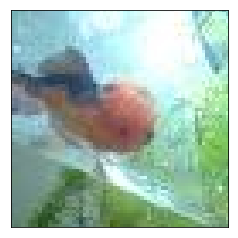

In [85]:
x,y = next(iter(model_data.val_dl))
show_img(model_data.val_ds.denorm(to_np(x))[0])

In [86]:
#on first pass y values in data.val_dl.dataset (in model.fit() vals = validate(stepper, data.val_dl, metrics)) were arrays of floats (0.0) instead of integers
#problem was with is_single = np.all(label_arr.sum(axis=1)==1), I re-parsed the labels joining words by underscore and converting to lowercase which fixed this issue

In [87]:
learn = ConvLearner.pretrained(f_model, model_data, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [88]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  3%|▎         | 34/1250 [00:01<00:57, 21.32it/s, loss=6]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 68%|██████▊   | 849/1250 [00:27<00:12, 31.19it/s, loss=14]  


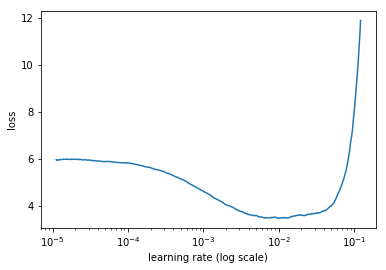

In [89]:
learn.sched.plot()

In [90]:
lr = 1e-3

In [91]:
learn.fit(lrs=lr, n_cycle=1, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      2.783762   2.403897   0.423223  
    1      2.543913   2.261125   0.452726  
    2      2.465761   2.244014   0.45597   



[2.2440135, 0.45597044728434505]

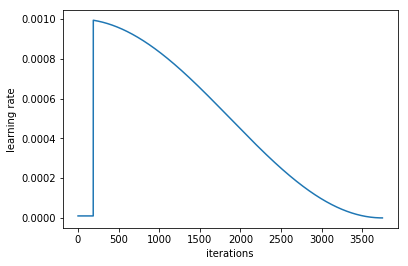

In [92]:
learn.sched.plot_lr()

In [93]:
lrs = np.array([lr/1000, lr/100, lr])

In [94]:
learn.freeze_to(-2)

In [95]:
lrf = learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 73%|███████▎  | 915/1250 [01:05<00:23, 14.06it/s, loss=12.5]

In [96]:
learn.fit(lrs=lrs/5, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  6%|▌         | 69/1250 [00:05<01:26, 13.58it/s, loss=3.3] 

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/walle/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy   
    0      2.927465   2.614723   0.392622  



[2.6147227, 0.3926218051118211]

In [97]:
learn.unfreeze()

In [98]:
learn.fit(lrs=lrs/5, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      2.781829   2.47646    0.417682  



[2.47646, 0.4176817092651757]

In [99]:
learn.save('clas_one')

In [100]:
learn.load('clas_one')

In [101]:
x, y = next(iter(model_data.val_dl))
x[0]


(0 ,.,.) = 
  0.1083 -0.0287  0.0912  ...   0.5364 -0.0458  0.3652
 -0.0629 -0.0801  0.1426  ...   1.1872  1.0502  0.3481
 -0.0629 -0.0287  0.2453  ...   1.2728  1.2385  0.9474
           ...             ⋱             ...          
 -0.4568 -0.4397 -0.4226  ...  -0.2684 -0.1314  0.6563
 -0.4054 -0.4911 -0.4739  ...  -0.1486 -0.2171  0.1939
 -0.4568 -0.5767 -0.5082  ...  -0.3883 -0.2684 -0.2342

(1 ,.,.) = 
  1.2731  1.1331  1.1856  ...   1.7458  1.1856  1.6758
  1.0980  1.0630  1.2381  ...   2.3761  2.3235  1.6758
  1.0805  1.1155  1.3431  ...   2.4286  2.4286  2.2885
           ...             ⋱             ...          
  0.2227  0.2402  0.2752  ...   0.5728  0.6779  1.4832
  0.2752  0.1877  0.2227  ...   0.6954  0.6254  1.0455
  0.2227  0.1001  0.1877  ...   0.4328  0.5553  0.5903

(2 ,.,.) = 
  1.5594  1.4200  1.4897  ...   1.6814  1.2457  1.7337
  1.3851  1.3502  1.5420  ...   2.2740  2.2914  1.6640
  1.3677  1.4025  1.6814  ...   2.2566  2.3437  2.1346
           ...            

In [102]:
batch_preds = predict_batch(learn.model, x)

In [103]:
batch_preds

Variable containing:
-7.3543e+00 -7.5430e+00 -2.5937e+00  ...  -7.1897e+00 -6.4899e+00 -7.8707e+00
-1.3972e+01 -1.5863e+01 -1.4570e+01  ...  -1.3933e+01 -1.4269e+01 -1.4581e+01
-7.1615e+00 -6.9494e+00 -3.5953e+00  ...  -4.9075e+00 -6.9942e+00 -6.6862e+00
                ...                   ⋱                   ...                
-1.3360e+01 -1.5603e+01 -1.2565e+01  ...  -1.1169e+01 -9.6781e+00 -1.5230e+01
-1.5051e+01 -1.5925e+01 -1.4599e+01  ...  -1.6358e+01 -1.4510e+01 -1.5288e+01
-6.8588e+00 -8.2667e+00 -9.4583e+00  ...  -6.2696e+00 -6.2833e+00 -7.3844e+00
[torch.cuda.FloatTensor of size 64x200 (GPU 0)]

In [104]:
probs = F.softmax(batch_preds, -1)
probs

Variable containing:
 6.3986e-04  5.2980e-04  7.4744e-02  ...   7.5433e-04  1.5187e-03  3.8176e-04
 8.5474e-07  1.2901e-07  4.7033e-07  ...   8.8875e-07  6.3519e-07  4.6534e-07
 7.7590e-04  9.5921e-04  2.7451e-02  ...   7.3908e-03  9.1722e-04  1.2480e-03
                ...                   ⋱                   ...                
 1.5777e-06  1.6731e-07  3.4931e-06  ...   1.4100e-05  6.2644e-05  2.4308e-07
 2.9056e-07  1.2132e-07  4.5661e-07  ...   7.8704e-08  4.9929e-07  2.2927e-07
 1.0502e-03  2.5694e-04  7.8040e-05  ...   1.8930e-03  1.8672e-03  6.2088e-04
[torch.cuda.FloatTensor of size 64x200 (GPU 0)]

In [105]:
x = to_np(x)
preds = to_np(probs)

In [106]:
preds = np.argmax(preds, -1)

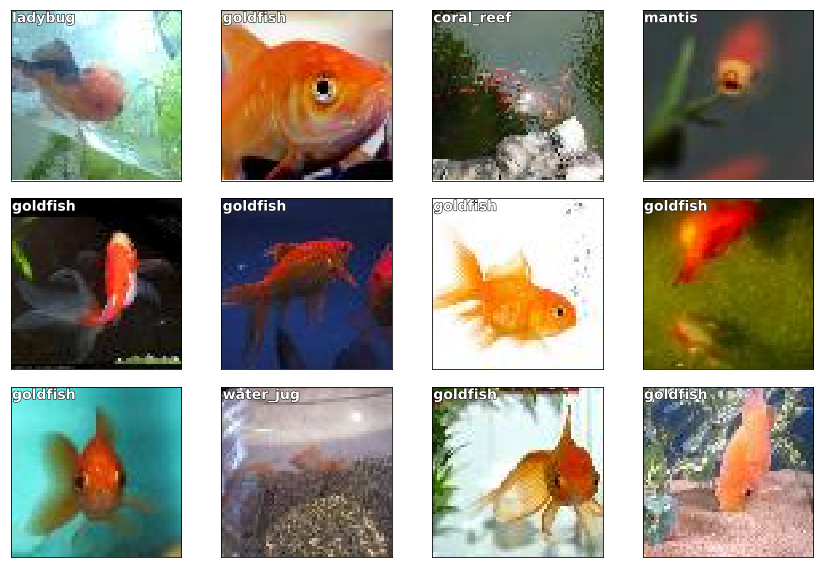

In [107]:
#draw the predictions
fig, axes = plt.subplots(3, 4, figsize = (12, 8))
for i,ax in enumerate(axes.flat):
    ima=model_data.val_ds.denorm(x)[i]
    b = model_data.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0, 0), b)
plt.tight_layout()
plt.show()

Needs some work...

## Single object detection

In [108]:
trn_ids = list(trn_fns.keys())

In [109]:
BB_CSV = PATH/'tmp/bb.csv'

bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
#want space sep data
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 'n01443537_0.JPEG,0 10 63 58\n',
 'n01443537_1.JPEG,14 2 54 49\n',
 'n01443537_10.JPEG,1 17 58 56\n',
 'n01443537_100.JPEG,5 12 63 56\n']

In [110]:
#bounding box and largest object
f_model = resnet34
sz = 64
bs = 64

In [111]:
val_idxs = get_cv_idxs(len(trn_fns))

In [112]:
augs = [RandomFlip(), RandomRotate(20), RandomLighting(b=0.1, c=0.1)]
tfms = tfms_from_model(f_model,sz=sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
#BB_CSV contains only filename, bbox coords
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, bs=bs, tfms=tfms, continuous=True, val_idxs=val_idxs)
print(f'{type(md)}, size: {md.sz}')

<class 'fastai.dataset.ImageClassifierData'>, size: 64


In [113]:
tfms2 = tfms_from_model(f_model, sz=sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
#note we are reading in the CSV not BB_CSV, CSV contains only filename, category
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, bs=bs, tfms=tfms2)
md2.sz

64

In [114]:
class ConcatLblDataset(Dataset):
    #take existing ds which has existing independent and dependant vars, add in dependent y2
    #extends torch Dataset, which requires one to override the methods below
    #sz property added as is required by learner (lean.summary())
    def __init__(self, ds, ds2):
        #I changed this to use seconds dataset rater than just y to help me understand this
        self.ds = ds
        self.ds2 = ds2
        
    def __len__(self):
        assert len(self.ds) == len(self.ds2)
        return len(self.ds)

    def __getitem__(self, i):
        x, y = self.ds[i]
        x2, y2 = self.ds2[i]
        #these should contain exactly the same info, so we only need to keep one. However this test fails
        #assert np.array_equal(x,x2)
        return (x, (y, y2))
    
    @property
    def sz(self):
        x, y = self.ds[0]
        print(f'sz: {x.shape[1]}')
        return x.shape[1]

In [115]:
#the bbox tagets
md.trn_ds.y

array([[ 0., 10., 63., 58.],
       [14.,  2., 54., 49.],
       [ 1., 17., 58., 56.],
       ...,
       [32., 21., 62., 57.],
       [ 0.,  2., 63., 63.],
       [16., 16., 51., 49.]], dtype=float32)

In [116]:
#classification dependent variable
md2.trn_ds.y

array([86, 86, 86, ...,  2,  2,  2])

In [117]:
#NB I changed the ConcatLblDataset. now it takes two datasets
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_ds)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_ds)

In [118]:
val_ds2[0][1]

(array([ 0., 11., 41., 48.], dtype=float32), 86)

In [119]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2
print(f'{type(md)}')

<class 'fastai.dataset.ImageClassifierData'>


In [120]:
x, y = next(iter(md.val_dl))
idx=50
ima = md.val_ds.ds.denorm(to_np(x))[idx]
#b = bb_hw(to_np(y[0][idx])); b
b = to_np(y[0][idx]); b

array([37., 16., 59., 60.], dtype=float32)

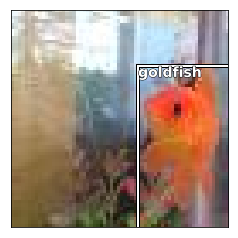

In [121]:
ax = show_img(ima)
draw_rect(ax,b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])
plt.show()

In [122]:
#replace head, add an extra linear layer and add dropout
head_reg4 = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    #this is a helper linear layer
    nn.Linear(in_features=512*7*7, out_features=256),
    nn.ReLU(),
    #1d as we have flattened 
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    #note at this stage we only have 256 in_features
    nn.Linear(in_features=256, out_features= 4+len(cats))
)

In [123]:
#ConvnetBuilder(f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None)
model_arch = ConvnetBuilder(f=f_model, c=0, is_multi=False, is_reg=False, custom_head=head_reg4)

In [124]:
learn = ConvLearner(data = md, models = model_arch)

In [125]:
learn.opt_fn = optim.Adam

In [126]:
def detn_loss(input, target):
    bb_t, c_t = target
    #first dim is batch dim, input first 4, and 4 onwards elements
    bb_i, c_i = input[:, :4], input[:, 4:]
    #for bb_i we know they will be b/w 0 & 224
    #use sigmoid to force b/w 0&1 and force the range
    bb_i = F.sigmoid(bb_i)*224
    #scalar for classifications based on what works
    combined_loss = F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20
    return combined_loss
    
def detn_l1(input, target):
    bb_t, _ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    f1_loss = F.l1_loss(V(bb_i), V(bb_t)).data
    return f1_loss

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:,4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

In [127]:
learn.lr_find()
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/1250 [00:00<?, ?it/s]


RuntimeError: size mismatch at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCTensorMathBlas.cu:247

In [ ]:
lr=1e-3
#use_clr sets shed to use CircularLR
learn.fit(lrs=lr, n_cycle=1, cycle_len=3, use_clr=(32,5))

In [ ]:
learn.save('reg1_0')

In [ ]:
layer_groups = learn.get_layer_groups()
print(f'{layer_groups}, {len(layer_groups)}')

In [ ]:
#set to trainable the last two layer groups only 
learn.freeze_to(-2) 

In [ ]:
lrs = np.array([lr/100, lr/10, lr])

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [ ]:
learn.fit(lrs/5, n_cycle=1, cycle_len=5, use_clr=(32,10))

In [ ]:
learn.save('reg1_1')

In [ ]:
learn.load('reg1_1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs=lrs/10, n_cycle=1, cycle_len=10, use_clr=(32, 10))

In [ ]:
learn.save('reg1')


In [ ]:
learn.load('reg1')

In [ ]:
preds = learn.predict()
x, _ = next(iter(md.val_dl))

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    #val_ds is val_dl.dataset but val_ds.ds?, 
    #.denorm is a method in FilesDataset where we reverse the normalization done to a batch of images
    ima = md.val_ds.ds.denorm(to_np(x))[i]
    #module scipy.special._ufuncs: The expit function, also known as the logistic function, is defined as
    #expit(x) = 1/(1+exp(-x)). It is the inverse of the logit function
    print(f'preds[i][:4]: {preds[i][:4]}')
    bb = expit(preds[i][:4])*64
    print(f'bb: {bb}')
    #b = bb_hw(bb)
    c = np.argmax(preds[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, bb)
    draw_text(ax, bb[:2], md2.classes[c])
plt.tight_layout()